In [266]:
#Data website: 
# https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.


# First, we read in the file and import packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture as GMM

import warnings
warnings.filterwarnings("ignore")

In [267]:
# Load the HCC data
DBdata = pd.read_csv('diabetes_data_upload.csv')

In [268]:
DBdata.shape

(520, 17)

In [269]:
DBdata.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [270]:
DBdata.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [271]:
# first, we should convert all the "Yes" into 1 and "No" into 0.
# the way to do this would be to map a dictionary into python
binary_dict = {'Yes':1, 'No':0}
gender_dict = {'Male':0, 'Female':1}

In [272]:
DBdata_copy = DBdata.copy()

for name in DBdata.columns[2:-1]:
    # every column is a pandas Series
    x = DBdata[name]
    DBdata_copy[name] = x.map(binary_dict)

DBdata_copy.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,Positive
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,Positive
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,Positive
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,Positive
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,Positive


In [273]:
# Great! Now we just have to conver the gender (ugh why binary again -.-) into numerical
# please, God if ur there i really hope that mutual-information disregards gender

DBdata_copy['Gender'] = DBdata['Gender'].map(gender_dict)
DBdata_copy.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,Positive
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,Positive
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,Positive
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,Positive
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,Positive


In [274]:
np.random.seed(40)

In [319]:
X = DBdata_copy.iloc[:, :-1]
y = np.asarray(DBdata_copy.iloc[:, -1])

# lets pick the K features with the highest mutual information relative to label
# one challenge would be to reduce the amount of features while still keeping
# the similar predictive quality from Density estimation

# let's have K = 3 
K = 3
selector = SelectKBest(mutual_info_classif, K)
X_reduced = selector.fit_transform(X,y) 
features_selected = selector.get_support()

In [320]:
# these are the 3 top features by the mutual-information score
feature_names_selected = np.where(features_selected==True)[0].tolist()
all_features = np.asarray(X.columns)
Kbest_features = all_features[feature_names_selected]

In [321]:
print(Kbest_features)

['Age' 'Polyuria' 'Polydipsia']


In [278]:
X_reduced.shape, y.shape

((520, 5), (520,))

In [287]:
# first we need to split X_reduced the training and testing datsets
# we're going to do a 60%-40% split on the training data and test data.
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, train_size=0.75)

In [288]:
# first we need to split X_train based on positive and negative class
X_pos = X_train[np.where(y_train=='Positive'),:][0]
X_neg = X_train[np.where(y_train=='Negative'),:][0]

In [289]:
X_pos.shape, X_neg.shape

((228, 5), (162, 5))

In [290]:
X_train.shape, X_test.shape

((390, 5), (130, 5))

In [ ]:
# t-SNE plot!



Great! Now, let's take the shortened dataset, 
and calculate the ditribution of X_reduced according to the labels
let's estimate the density (the likelihood) model!
let's first create M Gaussian Mixture models. We'll set M = 50.

In [291]:
M = 50
n_components = np.arange(2, M, 1)
pos_models = [GMM(n, covariance_type='tied', tol=1e-4) for n in n_components]
neg_models = [GMM(n, covariance_type='tied', tol=1e-4) for n in n_components]

In [292]:
# now tht the models were created, time to fit!
# we'll be using the Akaike Information Criteria (AIC) to judge whether
# the model may be overfitting or underfitting, find a balance

# nevermind i'm wrong AIC gives a relative measure of models, we still have to 
# the extra code lines here add a cute small progress bar :3 
import time
from tqdm import tqdm_notebook as tqdm

pos_aics = []
neg_aics = []

print("Fitting {} density models...".format(M))
for model in tqdm(pos_models):
    aic = model.fit(X_pos).aic(X_pos)
    pos_aics.append(aic)
    time.sleep(0.2)
    

print("Fitting {} density models...".format(M))
for model in tqdm(neg_models):
    aic = model.fit(X_neg).aic(X_neg)
    neg_aics.append(aic)
    time.sleep(0.2)

Fitting 50 density models...



Fitting 50 density models...


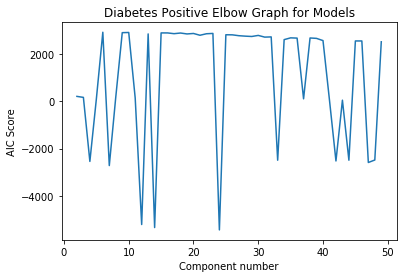

In [293]:
# plot the positive aic-curve
plt.xlabel('Component number')
plt.ylabel('AIC Score')
plt.title('Diabetes Positive Elbow Graph for Models')
plt.plot(n_components, pos_aics)
plt.show()

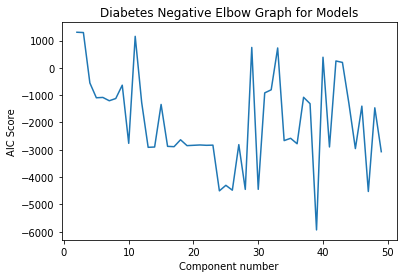

In [294]:
# plot the negative aic-curve
plt.xlabel('Component number')
plt.ylabel('AIC Score')
plt.title('Diabetes Negative Elbow Graph for Models')
plt.plot(n_components, neg_aics)
plt.show()

In [343]:
# from this, we should prolly choose  the elbow-point components for the 
# Positive_class density models
# and about the elbow-point components for the Negative_class models

gmm_pos = GMM(11, covariance_type='tied',tol=1e-4)
gmm_pos.fit(X_pos)
gmm_neg = GMM(15, covariance_type='tied',tol=1e-4)
gmm_neg.fit(X_neg)


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=15, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.0001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

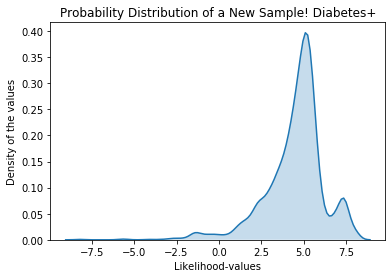

In [370]:
# this code below is credit to www.pythonprogramming.net
# so let's sample a fictitious new patient record from the gmm
N = 2000
sample_pos, _ = gmm_pos.sample(N)
sample_pos = sample_pos.astype(int)

sample_likelihoods_pos = gmm_pos.score_samples(sample_pos)

# lets plot the density for these n samples based on density+
plt.title('Probability Distribution of a New Sample! Diabetes+')
plt.ylabel('Density of the values')
plt.xlabel('Likelihood-values')
sns.kdeplot(sample_likelihoods_pos, shade=True)
plt.show()

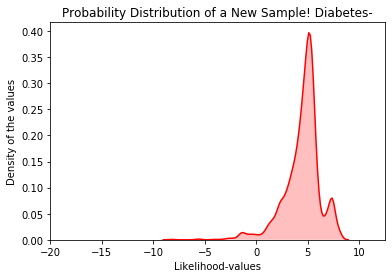

In [373]:
sample_neg, _ = gmm_neg.sample(N)
sample_neg = sample_neg.astype(int)


sample_likelihoods_neg = gmm_neg.score_samples(sample_neg)
# lets plot the density for these 10 samples based on density+
sns.kdeplot(sample_likelihoods_pos, shade=True, color='r')

# plot edits
plt.title('Probability Distribution of a New Sample! Diabetes-')
plt.ylabel('Density of the values')
plt.xlabel('Likelihood-values')
plt.xlim(-20.0,np.max(sample_likelihoods_neg)+1)
plt.show()

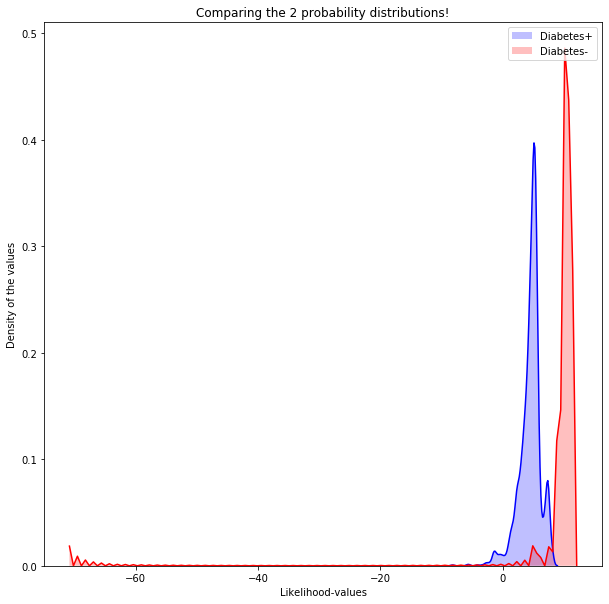

In [380]:
# hmmmm.....can wew somehow plot them TOGETHER?  we can show how the distributions
# and likelihoods intersect, which is powerful for data analysis!

plt.figure(figsize=(10,10))


diabetes_pos = sns.kdeplot(sample_likelihoods_pos, shade=True, color='b')
diabetes_neg = sns.kdeplot(sample_likelihoods_neg, shade=True, color='r')

# lets plot the density for these n samples based on density+
plt.title('Comparing the 2 probability distributions!')
plt.ylabel('Density of the values')
plt.xlabel('Likelihood-values')
plt.legend(['Diabetes+', 'Diabetes-'], loc='upper right')
plt.show()

In [359]:
Kbest_features

array(['Age', 'Polyuria', 'Polydipsia'], dtype=object)

Now in order to apply Gaussian Mixture modeling as a predictive tool, ket's go back to the Bayesian inference hypothesis equation above. Because we balanced the class labels in our dataset, the quotient $\frac{P(H_1)}{P(H_2)}$ is 1 because the ratio of life-labels to death-labels is the same. So we only have to worry about the likelihood ratio. 

Dividing numbers in Python can give weird errors, so instead, we'll work with the *logarithm* of the likelihood ratio, written as:

$$log(\frac{P(Data|H_1)}{P(Data|H_2)})$$

which can be written as:

$$LogLikelihoodOdds = log(P(Data|H_1) - log(P(Data|H_2))$$

The numerator we'll call *life_log_prob* and the denominator as *death_log_prob*.

Our key calculation is this: in the quotient of likelihoods, if the quotient is > 1, then the likelihood of the test data point under hypothesis 1 (class label=1) is higher than class label 0, so we classify it as "survival". Otherwise, it's classified as "death". When we take the logarithm of the likelihood ratio, what this classification rule translates to is that we classify the new data point as "survival" if the difference, $delta$ > 0, and "death" if $delta$ < 0.

In [360]:
log_density_pos = gmm_pos.score_samples(X_test)
log_density_neg = gmm_neg.score_samples(X_test)

In [361]:
log_likelihood_odds = np.subtract(log_density_pos, log_density_neg)

# in this case the prior proportions of labels in the training set is NOT 50:50, 
# so we need to incorporate the log-difference in the prior proportions first
num_pos = Counter(y_train)['Positive']
num_neg = Counter(y_train)['Negative']
log_prior_odds = np.repeat(np.log(num_pos/num_neg), len(log_likelihood_odds))

# calculate the log-posterior for each data point using log-version of Bayes formula
# this is the inference part
log_posterior_odds = np.add(log_likelihood_odds, log_prior_odds)

# finally put the results into a prediction list :)
gmm_predictions = [1 if x>0 else 0 for x in log_posterior_odds]
gmm_predictions = np.asarray(gmm_predictions)

In [362]:
results_dict = {'Positive':1, 'Negative': 0}
y_test_encode = np.vectorize(results_dict.get)(y_test)

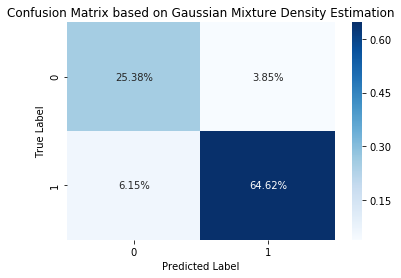

In [363]:
cf_matrix = cmatrix(y_true=np.asarray(y_test_encode), y_pred=gmm_predictions)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix based on Gaussian Mixture Density Estimation')
plt.show()

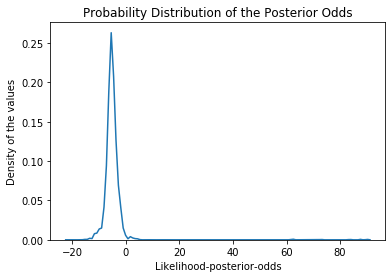

In [364]:
N = 2000
sample1, _ = gmm_pos.sample(N)
sample1 = sample1.astype(int)
sample2, _ = gmm_neg.sample(N)
sample2 = sample2.astype(int)

sample1_LL = gmm_pos.score_samples(sample1)
sample2_LL = gmm_neg.score_samples(sample2)
# we do the ".astype(int)" in order to convert all the generated new feature-values to 
# integers so they look similar (in integer value) to the original training set
# create the posterior odds
likelihood_logodds = np.subtract(sample1_LL, sample2_LL)
log_prior_odds = np.repeat(np.log(num_pos/num_neg), N)
posterior_logodds = np.add(likelihood_logodds, log_prior_odds)

# finally sns kdeplot
plt.title('Probability Distribution of the Posterior Odds')
plt.ylabel('Density of the values')
plt.xlabel('Likelihood-posterior-odds')
sns.kdeplot(posterior_logodds)
plt.show()